In [1]:
import os
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import uproot
import numpy as np
import awkward as ak
import hist
from hist import Hist
import matplotlib.pyplot as plt
import utils.analysis as au
from utils import clock_fit, mcp_fit
import utils.timewalk as tw
from multiprocessing import Pool
from dataclasses import asdict, dataclass
from scipy.stats import stats
from utils import plotting as tbplt
from importlib import reload
import mplhep as hep
plt.style.use(hep.style.CMS)


In [ ]:
data_path = "/media/etl/Storage/DESY_April_2025/merged/"
run_config = {
    "start": 116185,
    "stop": 116200,
    "module": 207,
    "bias": 215,
    "offset": 20,
    "beam_energy": 5,
    "power_mode": "high"
}
is_telescope_setup = True
##############################################################################

run_files = au.get_run_files(
    data_path, 
    run_config["start"], 
    run_config["stop"], 
    r'run_(\d+).root', 
    verbose=True)
print("NUM FOUND FILES:",len(run_files))
print("Run Config", run_config)

def load_events(chunk: list[str]):
    branches = ["row", "col", "tot_code", "cal_code", "toa_code", "mcp_volts", "mcp_seconds", "clock_seconds", "clock_volts", "chipid", 'nhits']
    raw_events = uproot.concatenate(chunk, branches)  

    clock_timestamp = clock_fit.calc_clock(
        raw_events.clock_seconds*1e9, raw_events.clock_volts, 0.25, 0.8, 0.5
    )
    nanoseconds, scaled_volts = mcp_fit.MCPSignalScaler.normalize(
        ak.to_numpy(raw_events['mcp_seconds']) * 1e9, 
        ak.to_numpy(raw_events['mcp_volts']), 
        signal_saturation_level=-0.55
    )
    peak_times, mcp_amplitude = mcp_fit.MCPSignalScaler.calc_mcp_peaks(nanoseconds, ak.to_numpy(raw_events['mcp_volts']))
    mcp_timestamp = mcp_fit.linear_interpolation(nanoseconds, scaled_volts, peak_times, threshold=0.4)

    del raw_events['mcp_seconds']
    del raw_events['mcp_volts']
    del raw_events['clock_seconds']
    del raw_events['clock_volts']

    # events = dict(zip(ak.fields(events), ak.unzip(events)))
    raw_events["mcp_timestamp"] = mcp_timestamp
    raw_events["mcp_amplitude"] = mcp_amplitude
    raw_events["clock_timestamp"] = clock_timestamp

    # DO CHIP SELECTION FOR MULTI READOUT BOARD
    flat_chipid = ak.flatten(raw_events.chipid).to_numpy()
    module = int(run_config['module'])
    chipid = (module<<2) + 1
    print(f"DETECTED THESE CHIPIDS IN DATA (chosen chipid={module}<<2={chipid}): {np.unique(flat_chipid)}")  

    shape_requirement = ak.num(raw_events.chipid) == ak.num(raw_events.row)
    if is_telescope_setup and not ak.all(shape_requirement):
        #for single chip/module tb setups we do not need to drop events
        # ---> especially because for some tb NO chipids have the same shape
        print(f'Chipid does not have same shape as row! {len(raw_events[shape_requirement])}/{len(raw_events)} had good chipid shapes. Cutting bad chipids...')
        bad_shapes = ak.num(raw_events.chipid) != ak.num(raw_events.row)
        print(f"Some bad chipid shapes: {raw_events[bad_shapes].chipid}")
        print(f"Corresponding rows: {raw_events[bad_shapes].row}")
        raw_events = raw_events[shape_requirement]
    elif ak.all(shape_requirement):
        print("Chipid has same shape as row/col!")

    ### Select the raw_events with the correct chipid
    if is_telescope_setup: # (logic is correct here from above conditionals)
        chipid_sel = (raw_events.chipid==chipid)
        raw_events = ak.zip({
            'mcp_timestamp': raw_events.mcp_timestamp,
            'mcp_amplitude': raw_events.mcp_amplitude,
            'clock_timestamp': raw_events.clock_timestamp,
            'row': raw_events.row[chipid_sel],
            'col': raw_events.col[chipid_sel],
            'toa_code': raw_events.toa_code[chipid_sel],
            'tot_code': raw_events.tot_code[chipid_sel],
            'cal_code': raw_events.cal_code[chipid_sel], 
            'nhits': raw_events.cal_code[chipid_sel]
        })

        num_chipid_evs = len(ak.flatten(raw_events.row))
        # if num_chipid_evs == 0:
        #     print(f"NO EVENTS WITH SELECTED MODULE ({module}) or CHIPID={module<<2}")
        #     exit()
        print(f"Number of events with chipid ({chipid}): {num_chipid_evs}/{len(raw_events)}")
    return raw_events

with Pool(processes=8) as pool:
    results = list(pool.imap(load_events, run_files, chunksize=10))
    raw_events = ak.concatenate(results)
print(raw_events)

Found runs:
['116185', '116186', '116187', '116188', '116189', '116190', '116191', '116192', '116193', '116195', '116196', '116197', '116198', '116199', '116200', '116201', '116202', '116203', '116204', '116205', '116206', '116207', '116208', '116209', '116210', '116211', '116212', '116213', '116214', '116215', '116216', '116217', '116218', '116219', '116220', '116221', '116222', '116223', '116224', '116225', '116226', '116227', '116228', '116229', '116230', '116231', '116232', '116233', '116234', '116235', '116236', '116237', '116239', '116240', '116241', '116242', '116244', '116245', '116246', '116247', '116248', '116249', '116251', '116252', '116253', '116254', '116255', '116256', '116257', '116258', '116259', '116260', '116261', '116262', '116263', '116265', '116266', '116267', '116268', '116269', '116270', '116271', '116272', '116273', '116274', '116275', '116276', '116277', '116278', '116279', '116281', '116282', '116283', '116284']
NUM FOUND FILES: 94
Run Config {'start': 116185

DETECTED THESE CHIPIDS IN DATA (chosen chipid=207<<2=829): [829 833]DETECTED THESE CHIPIDS IN DATA (chosen chipid=207<<2=829): [829 833]

Chipid has same shape as row/col!Chipid does not have same shape as row! 4999/5000 had good chipid shapes. Cutting bad chipids...

Some bad chipid shapes: [[]]
Corresponding rows: [[7]]
Number of events with chipid (829): 1941/5000
Number of events with chipid (829): 1856/4999
DETECTED THESE CHIPIDS IN DATA (chosen chipid=207<<2=829): [829 833]DETECTED THESE CHIPIDS IN DATA (chosen chipid=207<<2=829): [829 833]

Chipid has same shape as row/col!
Chipid does not have same shape as row! 4999/5000 had good chipid shapes. Cutting bad chipids...
Some bad chipid shapes: [[]]
Corresponding rows: [[3]]
Number of events with chipid (829): 1981/5000
Number of events with chipid (829): 1932/4999
DETECTED THESE CHIPIDS IN DATA (chosen chipid=207<<2=829): [829 833]
Chipid has same shape as row/col!
Number of events with chipid (829): 1920/5000
DETECTED THESE CHIP

In [15]:
# RESET THE EVENTS BACK TO WHAT WAS LOADED
events = ak.copy(raw_events)

# Cuts
@dataclass # so you can apply cuts later if you need to :)
class Thresholds:
    mcp_amp_low: float
    mcp_amp_high: float
    toa_code_low: float
    toa_code_high: float
    tot_code_low: float
    tot_code_high: float

    def toa_code_cut(self, toa_code:ak.Array):
        return ((toa_code>self.toa_code_low) & (toa_code<self.toa_code_high))
    
    def tot_code_cut(self, tot_code:ak.Array):
        return (tot_code>self.tot_code_low) & (tot_code<self.tot_code_high)
    
    def mcp_amp_cut(self, mcp_amplitude:ak.Array):
        return ((mcp_amplitude > self.mcp_amp_low) & (mcp_amplitude < self.mcp_amp_high))

thresholds = au.Thresholds(
    mcp_amp_high  = -0.30,
    mcp_amp_low   = -0.55,
    toa_code_high = 700,
    toa_code_low  = 20,
    tot_code_high = 500,
    tot_code_low  = 20
)

In [16]:
# Cal Mode Calculation
cal_mode = np.zeros((16,16))
for row in range(16):
    for col in range(16):
        pix_sel = (events.row==row)&(events.col==col)
        # Do we really need to cut on mcp signal here??
        cal_val = ak.flatten(events.cal_code[pix_sel & thresholds.mcp_amp_cut(events.mcp_amplitude)])
        #cal_val = ak.flatten(events.cal_code[pix_sel])
        if len(cal_val) != 0:
            cal_mode[row][col] = stats.mode(ak.to_numpy(cal_val))[0]
        else:
            cal_mode[row][col] = -999

cal_array = ak.zeros_like(events.row)
cut_eff_cal = 0
for row in range(16):
    for col in range(16):
        pix_sel = ((events.row==row)&(events.col==col))
        cal_array = ak.where(pix_sel, cal_mode[row][col], cal_array) # think about cal_array = cal_mode[events.row, events.col]                    
        # cal_sel = ((events.cal_code<(cal_mode[row][col]+2000)) & (events.cal_code>(cal_mode[row][col]-2000))) 
        # cut_eff_cal += int(ak.count_nonzero(pix_sel & cal_sel)) 

print(cut_eff_cal)
events['cal_mode'] = cal_array

0


In [18]:
# DT Calculation
time_bin = 3.125 / events.cal_mode
events['toa'] = 12.5 - time_bin * events.toa_code #ns
events['tot'] = ((2*events.tot_code - np.floor(events.tot_code/32))*time_bin) #ns
events['dt'] = events.toa - (events.mcp_timestamp - events.clock_timestamp) #ns

# if file_style=="fnal":# or file_style=='sps_oct':
#     events.dt -= au.fnalOffset(events)      
# if file_style=="DESY_April":
#     presel = presel & (events.dt > 0)

{'total': 260951, 'scope': 204341, 'toa_code_low': 199413, 'toa_code_high': 199413, 'tot_code_low': 199344, 'tot_code_high': 199344, 'cal_code': 199344, 'presel': 123383}


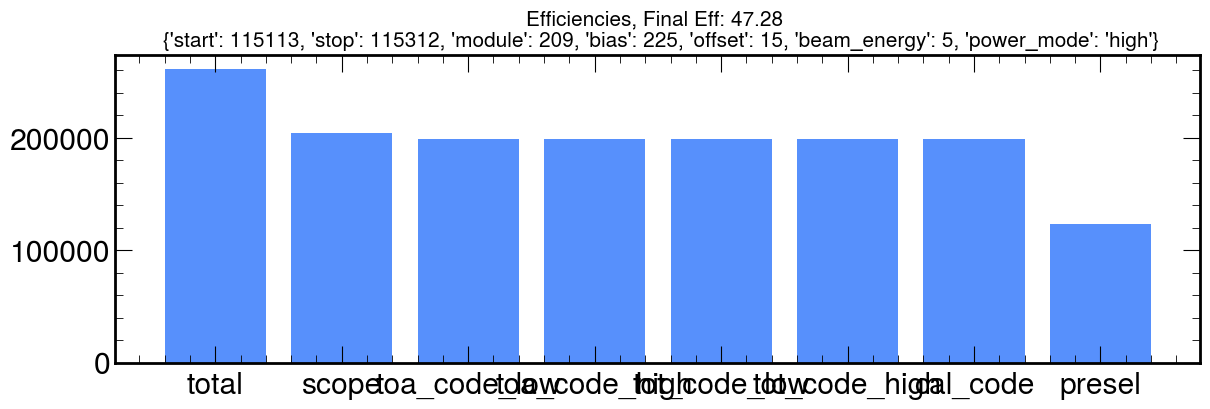

In [19]:
# Apply cuts
scope_sel = thresholds.mcp_amp_cut(events.mcp_amplitude)
toa_sel = thresholds.toa_code_cut(events.toa_code)
tot_sel = thresholds.tot_code_cut(events.tot_code)
cal_sel = abs(events.cal_code - cal_array) <= 5

presel = toa_sel & tot_sel & scope_sel & cal_sel & (events.dt > 0)

events_presel = ak.zip({
    'dt':       events.dt[presel],
    'toa':      events.toa[presel],
    'tot':      events.tot[presel],
    'row':      events.row[presel],
    'col':      events.col[presel],
    'toa_code': events.toa_code[presel],
    'tot_code': events.tot_code[presel],
    'cal_code': events.cal_code[presel],
    'cal_mode': events.cal_mode[presel]
})

cut_eff = {
    'total': int(ak.count_nonzero(events.nhits>0)),
    'scope': int(ak.count_nonzero(scope_sel & (events.nhits>0))),
    'toa_code_low': int(ak.count_nonzero(scope_sel & (events.toa_code>thresholds.toa_code_low))),
    'toa_code_high':int(ak.count_nonzero(scope_sel & toa_sel)),
    'tot_code_low':int(ak.count_nonzero(scope_sel & toa_sel & (events.tot_code>thresholds.toa_code_low))),
    'tot_code_high':int(ak.count_nonzero(scope_sel & toa_sel & tot_sel)),
    'cal_code': 0
}
for row in range(16):
    for col in range(16):
        pix_sel = ((events.row==row)&(events.col==col))
        cal_sel = ((events.cal_code<(cal_mode[row][col]+2)) & (events.cal_code>(cal_mode[row][col]-2))) 
        cut_eff['cal_code'] += int(ak.count_nonzero(pix_sel & toa_sel & tot_sel & scope_sel))

cut_eff['presel'] = int(ak.count_nonzero(presel))
# Plot the efficiency of cuts
print(cut_eff)
plt.figure(figsize=(14,4))
cut = list(cut_eff.keys())
passing = list(cut_eff.values())
plt.bar(cut, height=passing)
try:
    final_eff = passing[-1]/passing[0]*100
except:
    final_eff = 0.00
plt.title(f"Efficiencies, Final Eff: {final_eff:.2f} \n {run_config}", fontsize=15)
plt.show()

In [20]:
# Timewalk (Should get optimized...)
row_axis      = hist.axis.Integer(0, 16, name='row', label='row')
col_axis      = hist.axis.Integer(0, 16, name='col', label='row')
dt_axis       = hist.axis.Regular(1000, -25, 25, name="dt", label="time")
dt_corr_axis  = hist.axis.Regular(77,-1,1, name="dt", label="time")
tot_prof_axis = hist.axis.Regular(10, 3.5, 6.0, name="tot", label="tot")
dt_hist            = hist.Hist(dt_axis, row_axis, col_axis)
dt_corr_hist       = hist.Hist(dt_corr_axis, row_axis, col_axis)
dt_tot_hist        = hist.Hist(dt_axis, tot_prof_axis, row_axis, col_axis)
dt_tot_raw_data = {a:{b:{'dt':[], 'tot':[]} for b in range(16)} for a in range(16)}

TW_BINNING_CHOICES = ['unbinned','binned','twodbinned']
twBinning = TW_BINNING_CHOICES[0]
model = "cubicLM"

for row in range(16):
    for col in range(16):
        pix_sel = ((events_presel.row==row) & (events_presel.col==col))
        dt_flat = ak.flatten(events_presel['dt'][pix_sel])
        tot_flat = ak.flatten(events_presel['tot'][pix_sel])
        dt_tot_raw_data[row][col]['dt'] += dt_flat.to_list()
        dt_tot_raw_data[row][col]['tot'] += tot_flat.to_list()
        dt_tot_hist.fill(row=row, col=col, dt=dt_flat, tot=tot_flat)
        dt_hist.fill(row=row, col=col, dt=dt_flat)

start_timewalk_time=datetime.now()
print(f"STARTING TIMEWALK CALCULATION")

tw_corrections = [np.zeros((16,16)), np.zeros((16,16)), np.zeros((16,16)), np.zeros((16,16))]

res = np.zeros([16, 16])
res_corr = np.zeros([16, 16])

dt_corr_builder = ak.flatten(ak.copy(events_presel.dt)).to_numpy()
for row in range(16):
    for col in range(16):
        if twBinning == 'unbinned':
            tw_corrected = tw.calc_timewalk_corrections_unbinned(dt_tot_raw_data, row, col, model)
        elif twBinning == 'binned':
            tw_corrected = tw.calc_timewalk_corrections(dt_tot_hist, row, col, model)
        elif twBinning == 'twodbinned':
            tw_corrected = tw.calc_timewalk_corrections_2dbinned(dt_tot_hist, row, col, model)
            
        tw_corrections[0][row][col] = tw_corrected[0]
        tw_corrections[1][row][col] = tw_corrected[1]
        tw_corrections[2][row][col] = tw_corrected[2]
        tw_corrections[3][row][col] = tw_corrected[3]
        if tw_corrected[0] < -100:
            dt_corr = ak.ones_like(dt_tot_raw_data[row][col]['tot'])*-999
        else:
            dt = ak.Array(dt_tot_raw_data[row][col]['dt'])
            tot = ak.Array(dt_tot_raw_data[row][col]['tot'])
            dt_corr = dt - tw.predict(model, tot, tw_corrected)

        dt_corr_hist.fill(row=row, col=col, dt=dt_corr)

        #Calculate Resolution
        if fit_dt_outputs:= au.fit_gauss(dt_hist[{'row':row, 'col':col}]):
            popt = fit_dt_outputs[0]
            res[row,col] = popt[2]*1000 #ns to ps conversion :)
        else:
            res[row,col] = 0
        #Calculate TW Corrected Resolution
        if fit_dt_corr_outputs:= au.fit_gauss(dt_corr_hist[{'row':row, 'col':col}]):
            popt = fit_dt_corr_outputs[0]
            res_corr[row,col] = popt[2]*1000
        else:
            res_corr[row,col] = 0

        pix_sel = ak.flatten((events_presel.row == row) & (events_presel.col == col)).to_numpy()
        dt_corr_builder[pix_sel] = dt_corr.to_numpy()

events_presel['dt_corr'] = ak.unflatten(ak.from_numpy(dt_corr_builder), ak.num(events_presel.dt))

print(len(ak.flatten(events_presel['dt_corr'])))

STARTING TIMEWALK CALCULATION
123383


In [ ]:
# Optional saving
from utils.file_handler import save_json

output_data_path = "output_analysis_data/testing_notebook/"
ak.to_parquet(events, os.path.join(output_data_path, 'fullCollection.parquet'))
ak.to_parquet(events_presel, os.path.join(output_data_path, 'fullPresel.parquet'))

save_json(cal_mode, output_data_path, 'cal_mode')
save_json(au.hit_map(events), output_data_path, 'hit_map')
save_json(asdict(thresholds), output_data_path, 'thresholds.json')
#save_json(cut_eff, output_data_path, 'cut_eff.json')
save_json(tw_corrections, output_data_path, 'tw_corrections')
save_json(res, output_data_path,'res_heatmap')
save_json(res_corr, output_data_path,'res_corrected_heatmap')

### Time for analysis!!

895000 * var * {
    dt: float64,
    toa: float64,
    tot: float64,
    row: int64,
    col: int64,
    toa_code: int64,
    tot_code: int64,
    cal_code: int64,
    cal_mode: float64,
    dt_corr: float64
}


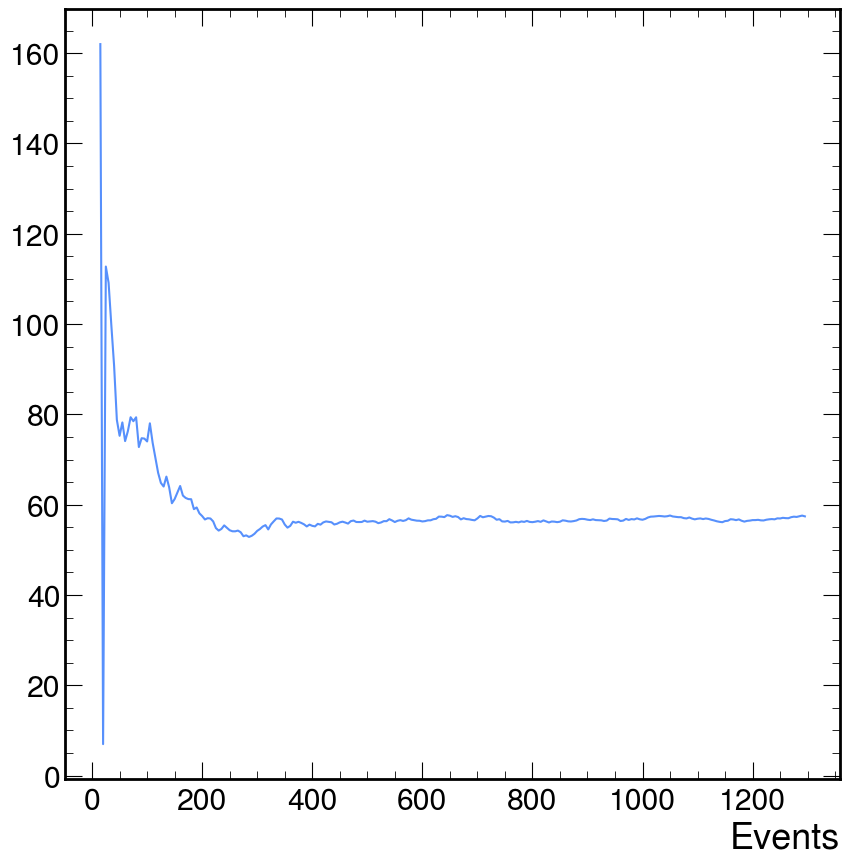

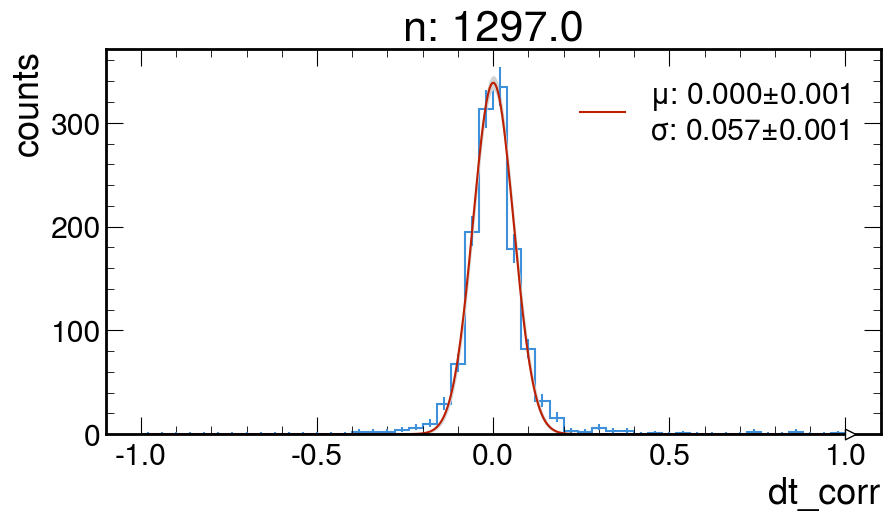

In [21]:
reload(tbplt)
reload(au)
events_presel.type.show()

tb = tbplt.TBplotRAW(events_presel, run_config=run_config, thresholds=thresholds)

dt_corr = tb.get_field_vals("dt_corr", pix=(7,7))

binnings = (50,-1,1)
step = 5
x = []
y = []
for i in range(1,1500):
    dt_corr_cut = dt_corr[:-i*step]
    hist_axis = hist.axis.Regular(*binnings, name="dt_corr")
    h = Hist(hist_axis).fill(dt_corr_cut)
    fit_params = au.fit_gauss(h)
    if not fit_params:
        continue
    popt, pcov, perr, red_chi2 = fit_params
    resolution = abs(popt[2])*1000
    x.append(len(dt_corr_cut))
    y.append(resolution)

plt.plot(x, y)
plt.xlabel("Events")

plt.figure(figsize=(10,5))
hist_axis = hist.axis.Regular(*binnings, name="dt_corr")
h2 = Hist(hist_axis).fill(dt_corr)
hep.histplot(h2, color=tbplt.COLORS[0])
tbplt.plot_gauss_fit(h2, color=tbplt.COLORS[2])
plt.xlabel("dt_corr")
plt.ylabel('counts')
plt.title(f"n: {sum(h2.values())}")
plt.legend()
plt.show()
